In [1]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import h5py
from ipywidgets import interact

# Import and Visualize Volumes

### Read .h5 files (Volumes)

In [3]:
from base import readH5

# Define file path for desired .h5 file
path = 'sample_pair.h5'

# Initialize variables through the readH5 method
fixed_vol, vol_to_align = readH5(path=path)

###### Accessing properties of loaded .h5 files

In [4]:
fixed_vol.shape

(385, 2048, 2048)

In [5]:
vol_to_align.shape

(443, 2048, 2048)

### View volume slice-by-slice using Matplotlib

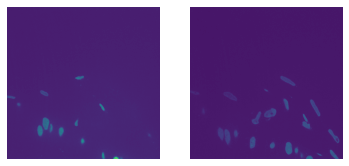

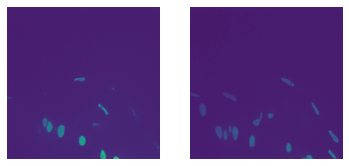

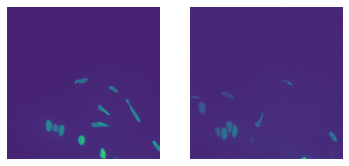

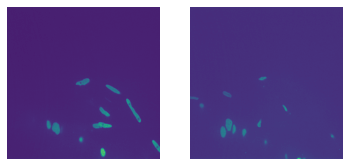

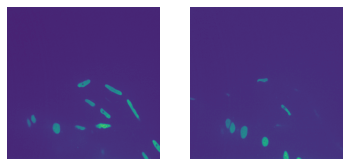

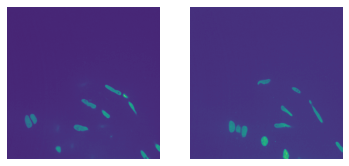

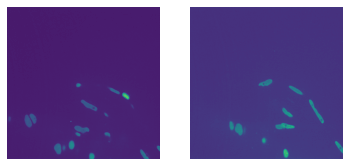

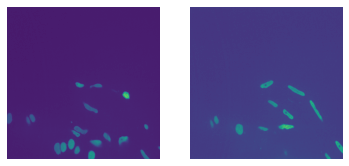

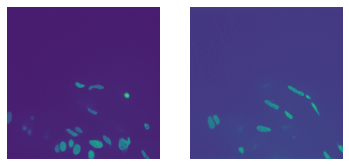

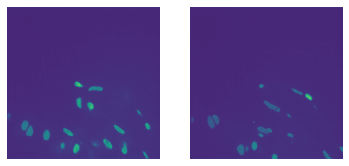

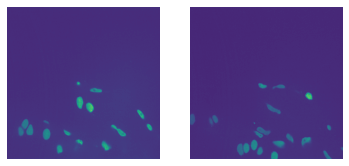

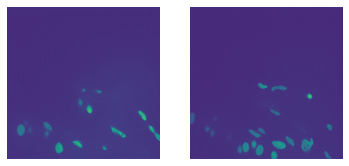

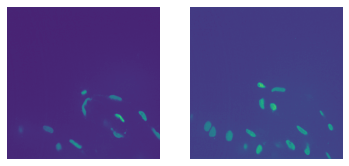

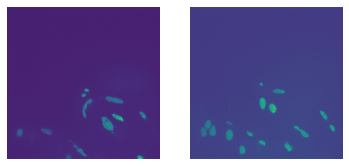

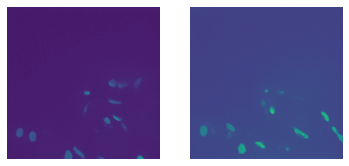

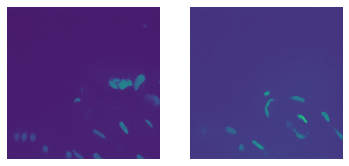

In [6]:
# Visualize slices in increments of twenty-five

for i in range(0, len(fixed_vol), 25):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(fixed_vol[i])
    ax1.axis('off')
    ax2.imshow(vol_to_align[i])
    ax2.axis('off')

It is highly recommended that you also view the volumes in 3D. For visualizing the volumes in 3D, the external application Fiji image viewer is recommended.

[Download and Install](https://fiji.sc/#download)

# Registration

### SimpleITK Rigid Transformation Baseline

Our baseline model is an affine SimpleITK model whose parameters can be found in build.py. Straightforward ways of improving this model are 1) experimenting with different parameters, and 2) adding in a non-rigid component such as Free Form deformation, BSpline based deformation, or Demons. A tutorial for implementing these advanced methods can be found  [here](https://simpleitk.org/SPIE2019_COURSE/05_advanced_registration.html).

In [7]:
from base import align

# Align two volumes. The baseline model works well on our example volume pair.

aligned, deformation = align(fixed_vol=fixed_vol, vol_to_align=vol_to_align)

In [8]:
# Output properties of the resulting deformation field

deformation.shape

(385, 2048, 2048, 3)

In [10]:
# Save deformation field to .h5 file

hf = h5py.File('deformation.h5', 'w')
hf.create_dataset('deformation', data=deformation)
hf.close()

## Check Alignment

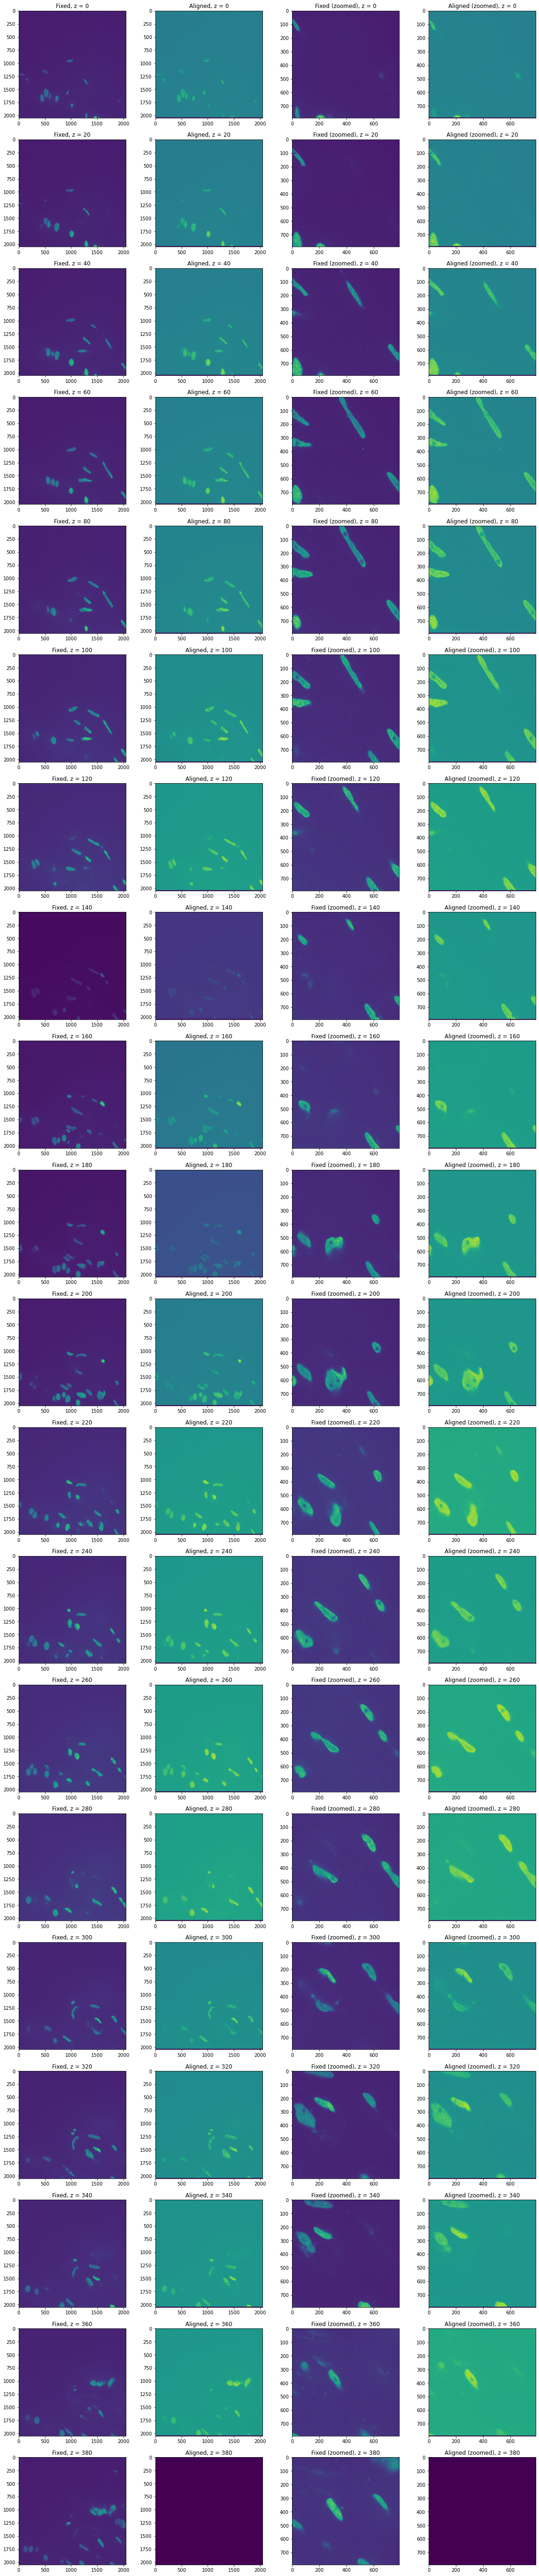

In [11]:
from base import checkAlignment

# Qualitatively check results
# ROI lets you look at a specific region of interest. 

checkAlignment(fixed_vol=fixed_vol, aligned_vol=aligned, ROI_min=[500,1250,1250], ROI_max=[600,2040,2040])

# Visualize Deformation Field

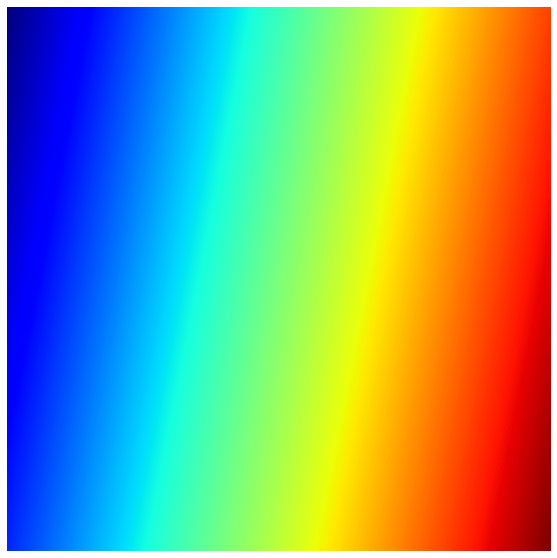

In [12]:
slice_index = aligned.shape[0]//2
image_slice = aligned[slice_index,:,:][::-1,::-1]

spacing = sitk.GetImageFromArray(aligned).GetSpacing()
size = sitk.GetImageFromArray(aligned).GetSize()

# extent = (left, right, bottom, top)
extent = (0, size[0] * spacing[0], size[1] * spacing[1], 0)

plt.figure(figsize=(10,10))

t = plt.imshow(image_slice,extent=extent,interpolation=None)

t.set_cmap("gray")

slice_index = deformation.shape[0]//2

df_slice = deformation[slice_index,:,:,:]

orientation = sitk.GetImageFromArray(deformation).GetDirection()
spacing = sitk.GetImageFromArray(deformation).GetSpacing()

orientation = np.array(orientation).reshape((3,3))
voxel_to_physical = ( spacing * np.identity(3) ) @ orientation
physical_to_voxel = np.linalg.inv(voxel_to_physical)

x = df_slice[:,:,0][::-1,::-1]
y = -df_slice[:,:,1][::-1,::-1]

coordsX = np.arange(0, size[0] * spacing[0], size[0] * spacing[0] / float(aligned.shape[2]) )
coordsY = np.arange(0, size[1] * spacing[1], size[1] * spacing[1] / float(aligned.shape[1]) )

coordsX, coordsY = np.meshgrid(coordsX, coordsY)

M = np.sqrt(x*x+y*y)

qq=plt.quiver(coordsX, coordsY, x, y, M, cmap=plt.cm.jet, units='x', scale=1)

plt.axis('off')
plt.show()